# Subreddit Recommender
### Exploratory Data Analysis

In [1]:
# DEPENDENCIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3


In [9]:
# GLOBAL VARIABLES


In [10]:
# IMPORT THE DATA

try:
    # import the data from csv
    data = pd.read_csv('reddit_user_subreddit.csv')
    
except:
    # import and run the sql query
    connection = sqlite3.connect('reddit_data.db')
    
    data = pd.read_sql_query(
        """
        SELECT O.username_id, O.subreddit_id, COUNT(O.utc) AS visits
            FROM
                Observation O
            GROUP BY O.username_id, O.subreddit_id
            ;
        """,
        connection
        )

    data.to_csv('reddit_user_subreddit.csv')
    
#             WHERE S.subreddit_id = O.subreddit_id
#                 Subreddit S,
    

In [5]:
data.head()

,username_id,subreddit_id,visits
0,0,412,2
1,0,568,1
2,0,608,7
3,0,1402,14
4,0,1460,9


In [8]:
# IMPORT OUR SUBREDDIT MAPPER
try: 
    # a second table to map the subreddit_id to the subreddit name, to be accessed after our recommender
    mapper_df = pd.read_csv('subreddit_mapper.csv')
    
except:
    connection = sqlite3.connect('reddit_data.db')
    mapper_df = pd.read_sql_query(
        """
        SELECT S.subreddit_id, S.subreddit FROM Subreddit S;
        """, connection)
    
    mapper_df.to_csv('subreddit_mapper.csv')

In [20]:
#Creating dictionary for subreddits

dict_subreddits = mapper_df['subreddit_id']
dict_subreddits.index = mapper_df['subreddit']
dict_subreddits = dict_subreddits.to_dict()
inv_dict_sub = {v: k for k, v in dict_subreddits.items()}
inv_dict_sub

{0: '007',
 1: '065_082_071',
 2: '0ad',
 3: '0x10c',
 4: '0x3642',
 5: '1000degreeknife',
 6: '1000thworldproblems',
 7: '100DayComicChallenge',
 8: '100DaysofKeto',
 9: '100kin',
 10: '100pushups',
 11: '100sexiest',
 12: '100yearsago',
 13: '101Wicca',
 14: '10202016',
 15: '1022',
 16: '1098thworldproblems',
 17: '10Sound',
 18: '10cloverfieldlane',
 19: '10mm',
 20: '112263Hulu',
 21: '1123581321345589',
 22: '11bx1371',
 23: '11foot8',
 24: '1200isjerky',
 25: '1200isplenty',
 26: '1200isplentyketo',
 27: '123moviesto',
 28: '125R',
 29: '12Monkeys',
 30: '12am',
 31: '12in12',
 32: '12ozmouse',
 33: '12thMan',
 34: '12winArenaLog',
 35: '13thage',
 36: '14ers',
 37: '1500isplenty',
 38: '1600x900Wallpapers',
 39: '16AngryBears',
 40: '1779xxx',
 41: '18650masterrace',
 42: '18_19',
 43: '18_20',
 44: '1911',
 45: '1911fans',
 46: '1914wasaSerbianJob',
 47: '195',
 48: '1970s',
 49: '1980s',
 50: '1984isreality',
 51: '1985sweet1985',
 52: '199999discussion',
 53: '19KidsandCount

In [ ]:
# https://www.youtube.com/watch?v=zvrRI0r6f2Q
# watch this video and learn how to read that CSV straight into a dictionary

import csv

In [ ]:
# CONSIDER CREATING A HOLDOUT DATASET FOR TESTING


In [23]:
# VISUALLY INSPECT THE DATA
data.head()
# data.tail()

,username_id,subreddit_id,visits
0,0,412,2
1,0,568,1
2,0,608,7
3,0,1402,14
4,0,1460,9


In [17]:
data.drop(columns = 'Unnamed: 0', inplace = True)

In [ ]:
data.rename()

In [18]:
# data.drop(labels = 'Unnamed: 0', axis = 1, inplace = True)
data.shape

(892462, 3)

In [19]:
# ASSESS - HOW MUCH DATA CLEANING IS NEEDED? 
data.info() # we can see that there are no null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 892462 entries, 0 to 892461
Data columns (total 3 columns):
username_id     892462 non-null int64
subreddit       892462 non-null object
COUNT(O.utc)    892462 non-null int64
dtypes: int64(2), object(1)
memory usage: 20.4+ MB


In [15]:
data.dtypes

Unnamed: 0       int64
username_id      int64
subreddit       object
COUNT(O.utc)     int64
dtype: object

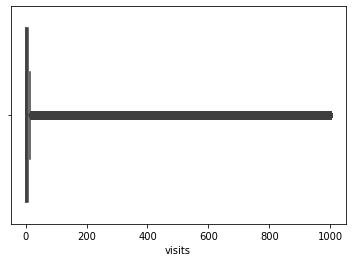

In [72]:
# LOOK AT THE DISTRIBUTION OF THE COUNTS
sns.boxplot(x = data['visits']) 

In [73]:
data2 = data.copy()

In [75]:
data2['usage'] = 0 # create an empty feature

for user in data2.head(100)['username_id'].unique():
    sum_  = data2[data2['username_id']==user]['visits'].sum()
    indices_ = data2[data2['username_id']==user].index
    data2['usage'].iloc[indices_] = data2['visits'].iloc[indices_] / sum_

/Users/sampoad/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [76]:
data2[ data2['username_id'] == 0]['usage'].sum() # confirm that a UserId's usage fraction adds to 1.

1.0

In [77]:
# look for users that only have 1 subreddit they've posted and drop?
# data2['usage'].dtype

data2[ data2['usage'] > 0.45]['usage'] # so here, we see only two subreddits have taken up over 45% of a user's engagement.

49    0.870968
63    0.895327
Name: usage, dtype: float64

In [80]:
# build a function for creating  the usage column

def calculate_usage(df):
    df['usage'] = 0
    for user in df['username_id'].unique():
        sum_ = df[ df['username_id'] == user]['visits'].sum()
        indices_ = df[ df['username_id'] == user].index
        df['usage'].iloc[indices_] = df['visits'].iloc[indices_] / sum_
    return df

In [81]:
calculate_usage(data).head() # test my function

,username_id,subreddit,visits,usage
0,0,AOImmortals,2,0.006116
1,0,Addons4Kodi,1,0.003058
2,0,AdviceAnimals,7,0.021407
3,0,AskReddit,14,0.042813
4,0,Assistance,9,0.027523


In [94]:
# function takes in our usage dataframe and transforms it to a pivot table
def to_matrix(df):
    return df.pivot(
        index='subreddit',
        columns='username_id',
        values='usage'
    ).fillna(0)


In [95]:
df_user_usage = to_matrix(data) # test my function

In [96]:
df_user_usage.head()

username_id,0,1,2,3,4,5,6,7,8,9,...,22600,22601,22602,22603,22604,22605,22606,22607,22608,22609
subreddit,,,,,,,,,,,,,,,,,,,,,
007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
065_082_071,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0ad,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x10c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x3642,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [104]:
df_user_usage.tail()

username_id,0,1,2,3,4,5,6,7,8,9,...,22600,22601,22602,22603,22604,22605,22606,22607,22608,22609
subreddit,,,,,,,,,,,,,,,,,,,,,
zweiteliga,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zxspectrum,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zyramains,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zyzz,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zzt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [98]:
from scipy.sparse import csr_matrix

mat_user_usage = csr_matrix(df_user_usage.values) # compress our matrix, build this into a function as well

mat_user_usage

<34967x22610 sparse matrix of type '<class 'numpy.float64'>'
	with 892462 stored elements in Compressed Sparse Row format>

In [103]:
# mat_df = pd.DataFrame(mat_user_usage)

print(mat_user_usage)

  (0, 9337)	0.03333333333333333
  (1, 10976)	0.005025125628140704
  (2, 8856)	0.005319148936170213
  (2, 16045)	0.003
  (3, 15521)	0.001
  (3, 19581)	0.004618937644341801
  (4, 48)	0.009
  (4, 711)	0.004016064257028112
  (4, 8040)	0.001001001001001001
  (4, 8937)	0.001
  (4, 9987)	0.0014388489208633094
  (4, 10397)	0.004
  (4, 11366)	0.0010351966873706005
  (4, 11528)	0.001658374792703151
  (4, 12153)	0.006
  (4, 15496)	0.01092896174863388
  (4, 19829)	0.006
  (4, 21868)	0.001145475372279496
  (4, 22071)	0.002
  (5, 8448)	0.015789473684210527
  (6, 1652)	0.001001001001001001
  (7, 10808)	0.15233415233415235
  (8, 2994)	0.002890173410404624
  (8, 6113)	0.001
  (8, 11222)	0.005
  :	:
  (34964, 435)	0.07671232876712329
  (34964, 885)	0.20588235294117646
  (34964, 1323)	0.008
  (34964, 1915)	0.07407407407407407
  (34964, 4540)	0.019148936170212766
  (34964, 5891)	0.012
  (34964, 6728)	0.002
  (34964, 7904)	0.01
  (34964, 9289)	0.002
  (34964, 10528)	0.00101010101010101
  (34964, 10718)	0.0

In [105]:
from sklearn.neighbors import NearestNeighbors

# Initialize the Model
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)

# fit the dataset
model_knn.fit(mat_user_usage)



NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=20, p=2,
                 radius=1.0)

In [ ]:

def fuzzy_matching(mapper, subreddit, verbose = True):
    

In [115]:
def make_recommendation(model_knn, data, subreddit, n_recommendations = 5): #, mapper
    # fit
    model_knn.fit(data)
    # get input movie index
    print('You have input subreddit:', subreddit)
#     idx = fuzzy_matching(
#         mapper,
#         subreddit,
#         verbose=True
#     )
    idx = subreddit
    print('Recommendation system start to make inference')
    print('......\n')
#     print(data[subreddit])
    distances, indices = model_knn.kneighbors(
        data[idx],
        n_neighbors=n_recommendations+1
    )
    raw_recommends = sorted(list(zip(
        indices.squeeze().tolist(),
        distances.squeeze().tolist()
    )),key=lambda x: x[1])[:0:-1]
    
    
    # get reverse mapper
#     reverse_mapper = {v: k for k, v in mapper.items()}
    # print recommendations
    
#     print(f"Recommendations for {subreddit}:")
#     for i, (rec, dist) in enumerate(raw_recommends):
#         print(f"{i+1}: {rec}, with distance of {dist}")

In [117]:
make_recommendation(
    model_knn = model_knn,
    data = mat_user_usage,
    subreddit = 'dataisbeautiful',
)

You have input subreddit: dataisbeautiful
Recommendation system start to make inference
......



IndexError: Index dimension must be <= 2